라이브러리 임포트

In [ ]:
from sklearn.svm import SVR  # Support Vector Regression 모델 가져오기
import numpy as np  # 수치 연산을 위한 NumPy 가져오기
import pandas as pd  # 데이터 조작을 위한 Pandas 가져오기
import matplotlib.pyplot as plt  # 그래프 그리기 위한 Matplotlib 가져오기
from google.colab import drive  # Google Colab 드라이브 모듈 가져오기
from pandas_datareader import data as pdr
from sklearn.metrics import mean_squared_error, r2_score  # 성능 평가

함수 정의

In [ ]:
def preprocess_stock_data(df):
    df.fillna(method='ffill', inplace=True)  # 누락된 값을 이전 값으로 채웁니다

    threshold = 1.5  # 임계값 설정
    for column in df.columns:
        for i in range(1, len(df)):
            if abs(df[column][i] - df[column][i - 1]) > threshold * df[column][i - 1]:
                # 현재 값과 이전 값의 차이가 임계값을 초과하면 이전 값으로 대체합니다
                df.at[i, column] = df.at[i - 1, column]

    return df

학습 데이터 전처리 / 가중치 설정

[1]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/01.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

       Open    High     Low   Close      Adj Close  Volume
0    254500  256000  247500  247500  234366.843750  214585
1    249000  250500  244500  250000  236734.203125  255475
2    250000  252000  248000  249500  236260.734375  130109
3    252000  255000  249000  252500  239101.515625  251361
4    248000  256500  244000  245000  231999.515625  317886
..      ...     ...     ...     ...            ...     ...
963  234000  234000  230500  233500  233500.000000       0
964  231500  233500  229500  230500  230500.000000       0
965  227500  232000  226500  229000  229000.000000       0
966  227000  228500  226000  227000  227000.000000       0
967  229000  229000  225500  225500  225500.000000       0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [227394.48354091]
다음 날 예측 (polynomial, HL):  [226839.29294366]
다음 날 예측 (RBF, HL):  [225381.87374455]
최종 예측 값: [226538.55007637]


성능지표 시각화

Linear 모델 MSE: 3589067.8867645753
Polynomial 모델 MSE: 1793705.5889387804
RBF 모델 MSE: 13953.812227659484
R2 스코어 (linear):  -0.14457081927374538
R2 스코어 (polynomial):  0.5953741355792852
R2 스코어 (RBF):  0.9958491395224263


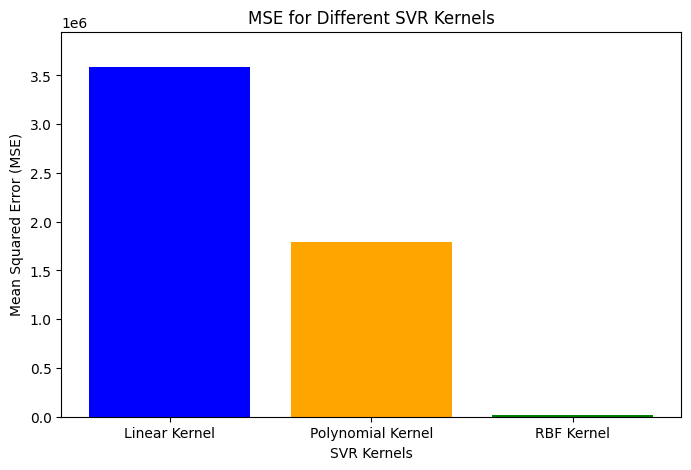

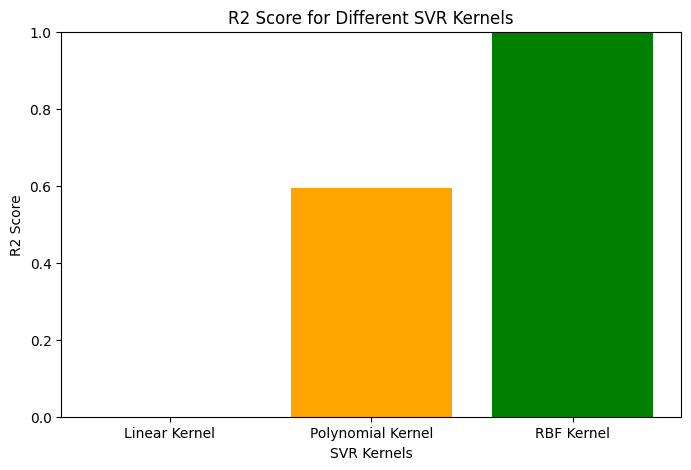

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

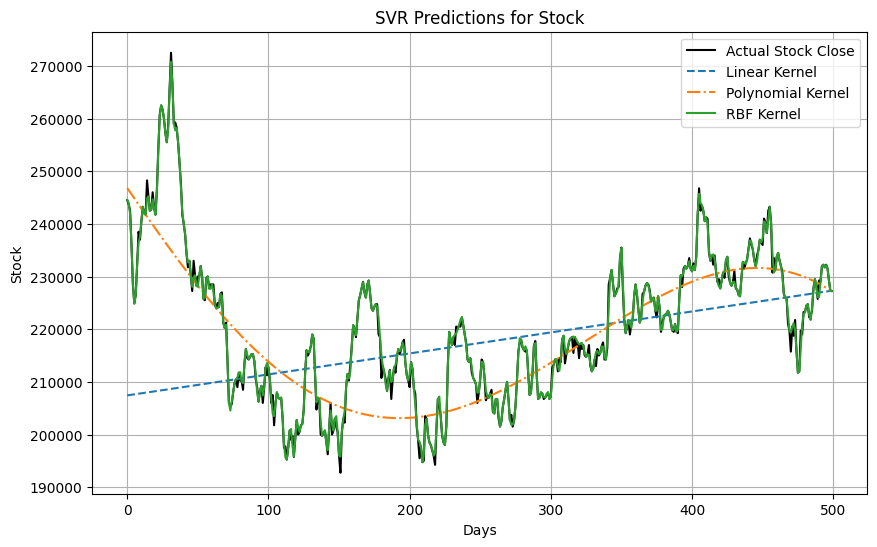

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[2]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/02.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

      Open   High    Low  Close     Adj Close   Volume
0    44100  44300  42300  42500  38135.832031  1355029
1    42600  42900  41500  42000  37687.175781  1569720
2    41350  41950  41350  41900  37597.449219   830880
3    41900  42300  41550  42050  37732.042969  1124218
4    41300  41900  41100  41300  37059.058594   997335
..     ...    ...    ...    ...           ...      ...
963  84900  84900  83700  84600  84600.000000        0
964  84200  86200  84200  86000  86000.000000        0
965  85800  86800  84700  85900  85900.000000        0
966  84800  86100  84400  85800  85800.000000        0
967  85200  86000  84000  84100  84100.000000        0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [80652.56891545]
다음 날 예측 (polynomial, HL):  [71906.04911597]
다음 날 예측 (RBF, HL):  [82063.21149907]
최종 예측 값: [78207.27651016]


성능지표 시각화

Linear 모델 MSE: 11884781.082690889
Polynomial 모델 MSE: 148692438.16219023
RBF 모델 MSE: 4148507.39752474
R2 스코어 (linear):  -0.02948779088957454
R2 스코어 (polynomial):  0.349052529136997
R2 스코어 (RBF):  0.9979448423135479


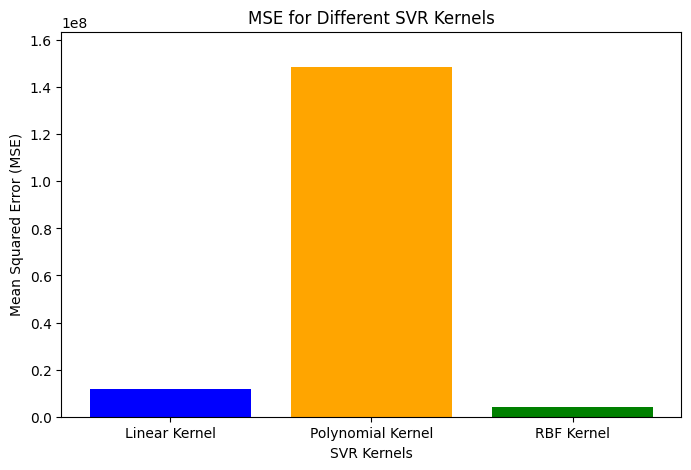

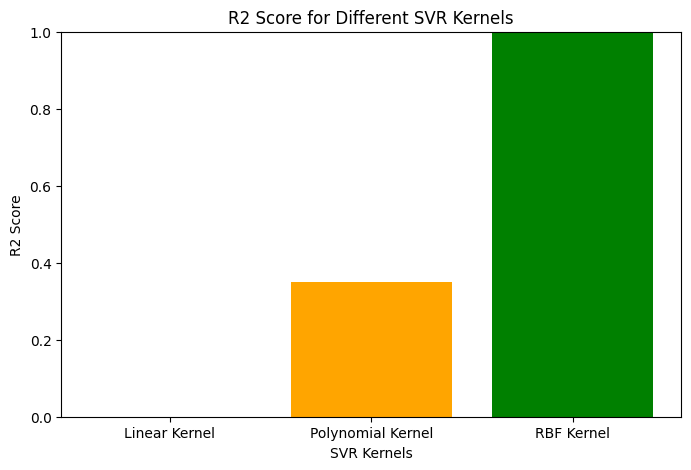

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

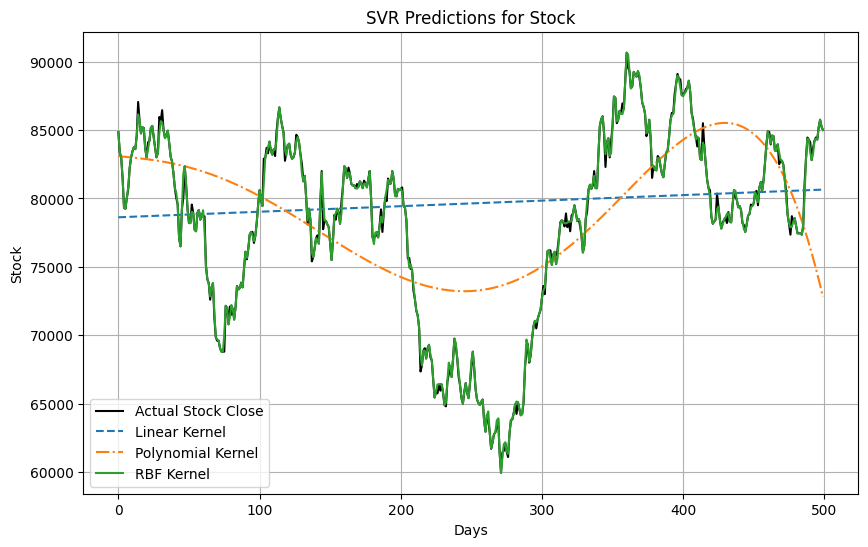

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[3]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/03.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

       Open    High     Low   Close      Adj Close   Volume
0     96000   96200   94100   94700   90833.937500  2342070
1     96500   97900   94300   94500   90642.101562  3021380
2     93000   95300   92800   94300   90450.265625  2577573
3     94500   95400   94000   94000   90162.515625  2489429
4     96400   99500   95200   97400   93423.718750  2489429
..      ...     ...     ...     ...            ...      ...
963  132100  132100  129900  131400  131400.000000        0
964  130200  131000  128900  130400  130400.000000        0
965  129900  133900  129900  133900  133900.000000        0
966  132200  133000  130800  132600  132600.000000        0
967  133400  134600  131100  131100  131100.000000        0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [109462.10317357]
다음 날 예측 (polynomial, HL):  [129518.79704451]
다음 날 예측 (RBF, HL):  [118558.64044723]
최종 예측 값: [119179.84688843]


성능지표 시각화

Linear 모델 MSE: 468198579.07127947
Polynomial 모델 MSE: 2500202.7864659345
RBF 모델 MSE: 157285699.4319023
R2 스코어 (linear):  -0.03456305031659257
R2 스코어 (polynomial):  0.8890096728473156
R2 스코어 (RBF):  0.9978624778216009


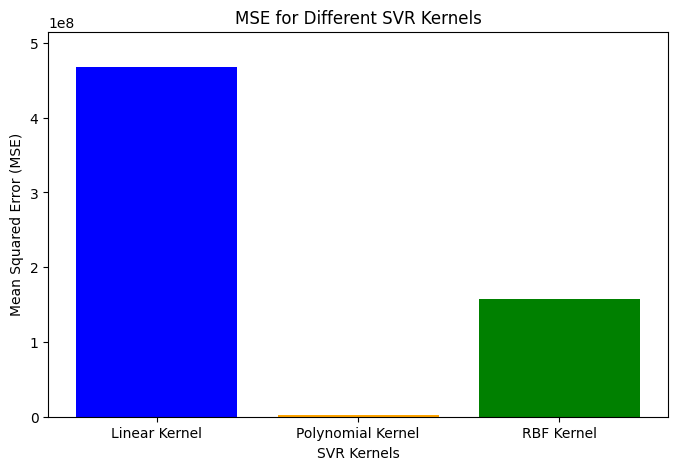

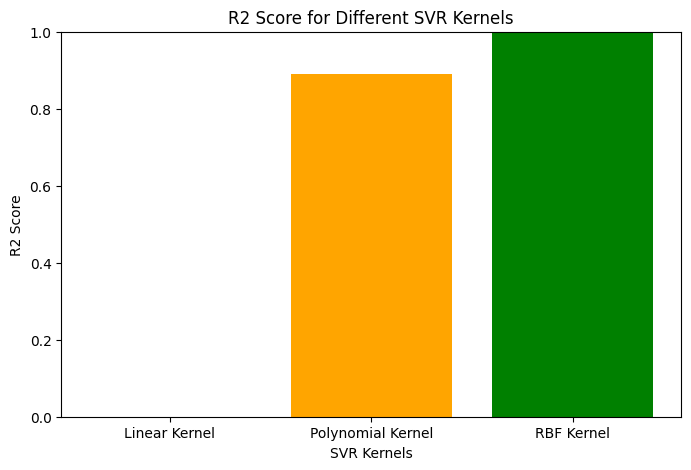

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

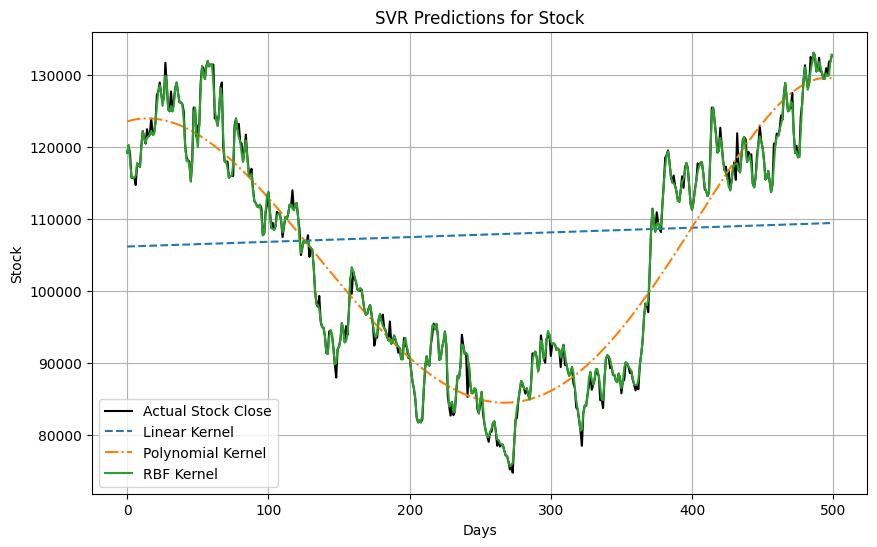

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[4]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/04.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

       Open    High     Low   Close      Adj Close  Volume
0    187500  188000  182000  182500  181167.046875  300640
1    185000  186000  180500  181500  180174.375000  454492
2    180000  182000  178000  180500  179181.671875  287970
3    182500  187000  181500  187000  185634.187500  328624
4    182000  183500  179000  183000  181663.406250  820867
..      ...     ...     ...     ...            ...     ...
963  208000  210000  204500  207500  207500.000000       0
964  208500  209000  205500  207500  207500.000000       0
965  206500  209500  206500  208000  208000.000000       0
966  208000  210000  204000  206000  206000.000000       0
967  208000  214000  207500  210500  210500.000000       0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [166550.19091071]
다음 날 예측 (polynomial, HL):  [189051.92561698]
다음 날 예측 (RBF, HL):  [231563.93827669]
최종 예측 값: [195722.01826813]


성능지표 시각화

Linear 모델 MSE: 1931585718.9847085
Polynomial 모델 MSE: 460019894.7397333
RBF 모델 MSE: 443689495.7241323
R2 스코어 (linear):  0.6050664317042788
R2 스코어 (polynomial):  0.9210748131795305
R2 스코어 (RBF):  0.9978205533054437


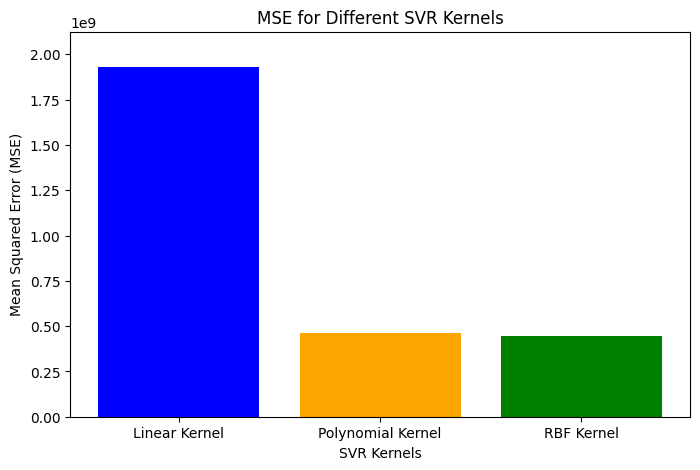

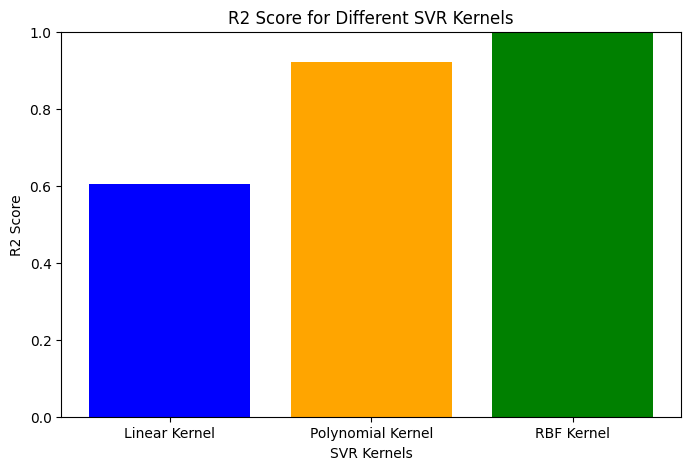

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

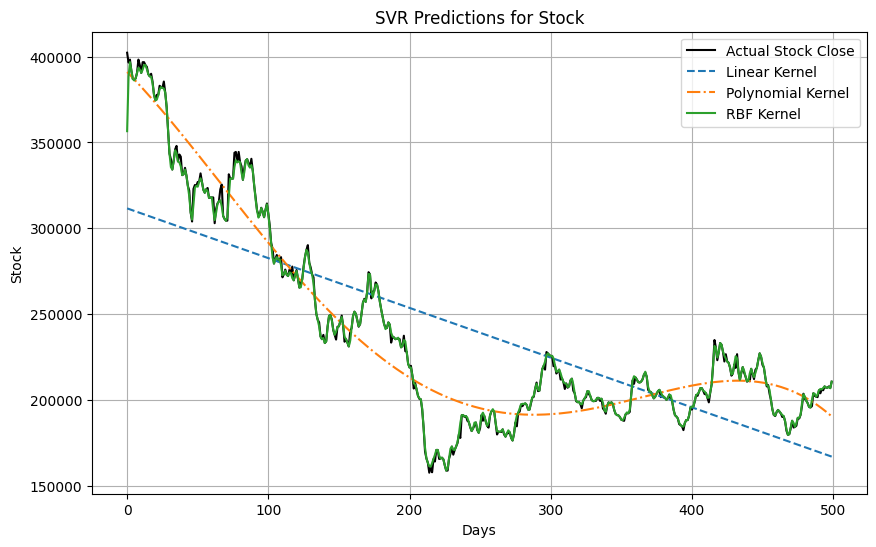

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[5]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/05.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

      Open   High    Low  Close     Adj Close    Volume
0    55500  56000  55000  55200  50037.414062  12993228
1    56000  56600  54900  55500  50309.355469  15422255
2    54900  55600  54600  55500  50309.355469  10278951
3    55700  56400  55600  55800  50581.292969  10009778
4    56200  57400  55900  56800  51487.773438  23501171
..     ...    ...    ...    ...           ...       ...
963  71400  72700  71300  72700  72700.000000         0
964  72400  72800  72200  72700  72700.000000         0
965  72700  72800  72200  72800  72800.000000         0
966  72400  72500  71700  72000  72000.000000         0
967  72800  72900  72400  72600  72600.000000         0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [66968.28142828]
다음 날 예측 (polynomial, HL):  [69950.52282267]
다음 날 예측 (RBF, HL):  [70873.3669669]
최종 예측 값: [69264.05707262]


성능지표 시각화

Linear 모델 MSE: 31716254.071021914
Polynomial 모델 MSE: 7019729.313198183
RBF 모델 MSE: 2981261.6309792628
R2 스코어 (linear):  -0.015676111736768528
R2 스코어 (polynomial):  0.8704206925983016
R2 스코어 (RBF):  0.9986483782062144


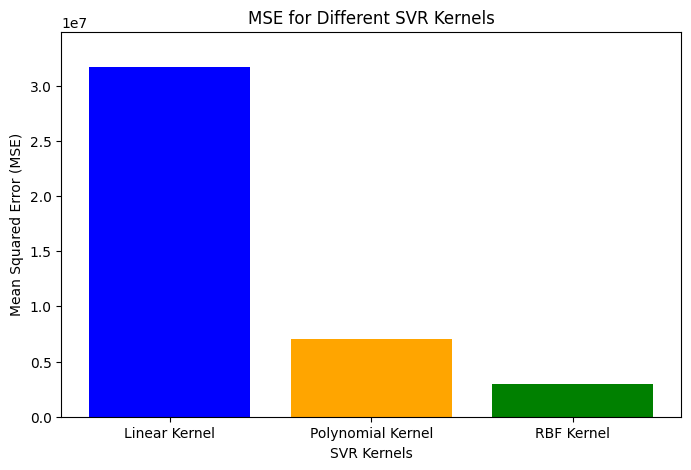

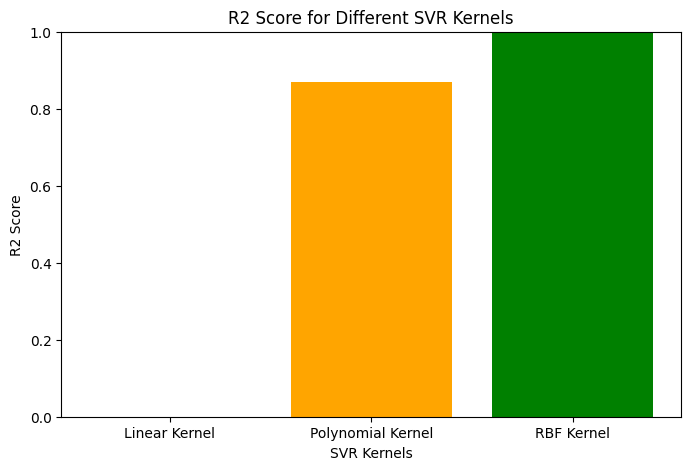

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

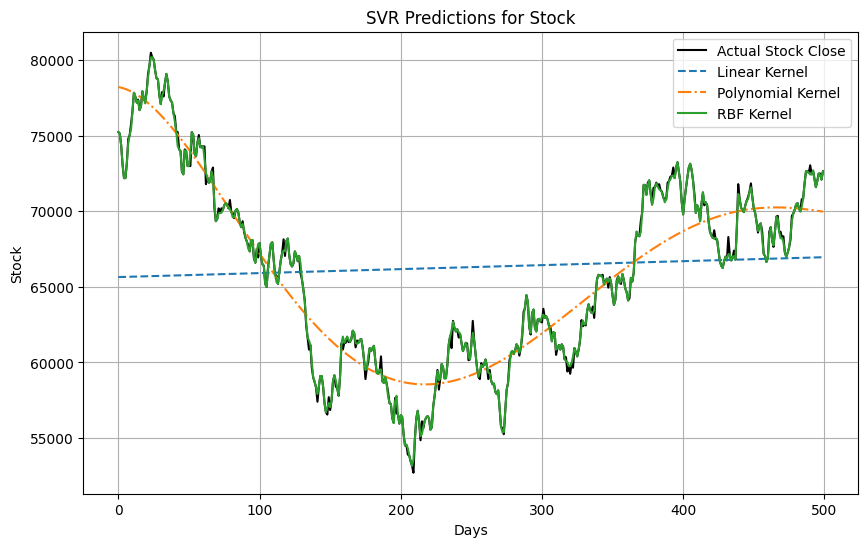

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[6]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/06.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

       Open    High     Low   Close      Adj Close   Volume
0    121000  121000  118000  118000  107800.992188   556532
1    118500  119000  115000  116000  105973.867188  1145187
2    116000  117000  115500  116000  105973.867188   334574
3    116500  117000  115500  115500  105517.078125   674196
4    115000  115500  111500  112000  102319.578125  1044825
..      ...     ...     ...     ...            ...      ...
963  185900  185900  183600  185700  185700.000000        0
964  185700  186500  184700  184800  184800.000000        0
965  184200  184900  182100  184300  184300.000000        0
966  183300  183800  181700  182800  182800.000000        0
967  183900  184100  181600  181600  181600.000000        0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [186756.53538043]
다음 날 예측 (polynomial, HL):  [155460.8156812]
다음 날 예측 (RBF, HL):  [183872.23977689]
최종 예측 값: [175363.19694618]


성능지표 시각화

Linear 모델 MSE: 26589857.12966234
Polynomial 모델 MSE: 683256956.8519741
RBF 모델 MSE: 5163073.603690231
R2 스코어 (linear):  -0.011311669412470193
R2 스코어 (polynomial):  0.35783304902347757
R2 스코어 (RBF):  0.9964650584669934


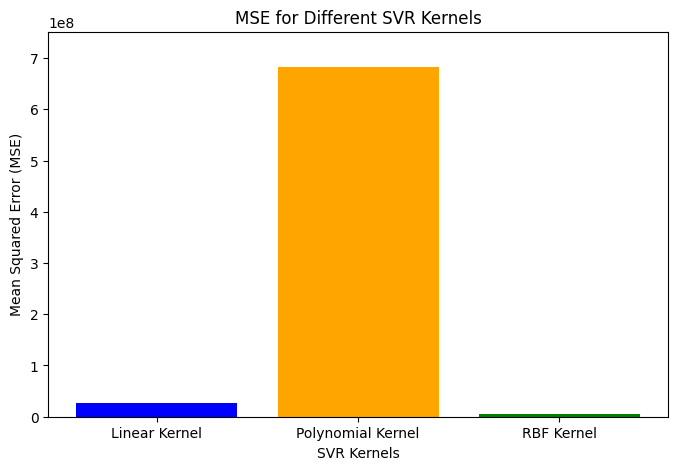

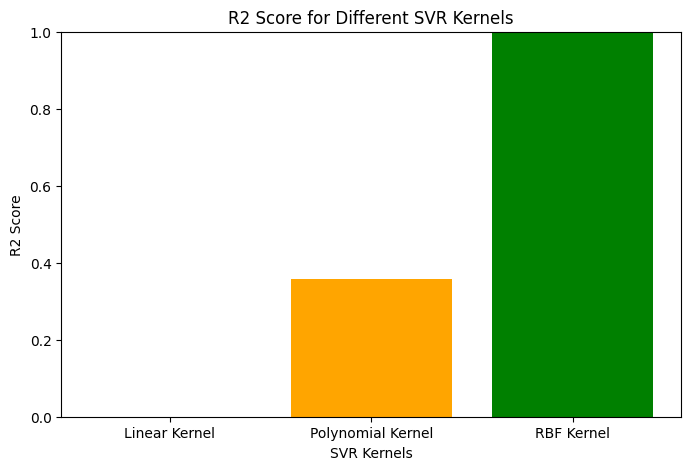

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

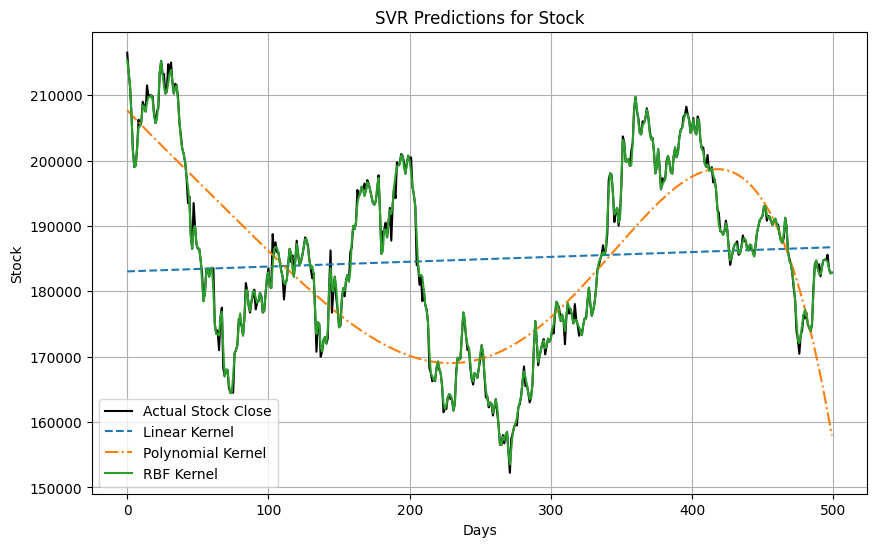

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[7]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/07.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

       Open    High     Low   Close     Adj Close  Volume
0    321000  321000  313500  314000  299408.90625  139496
1    317000  318500  310500  311000  296548.34375  165030
2    308000  311000  306500  307000  292734.18750  138154
3    306000  313500  305000  311000  296548.34375  133788
4    306000  307000  301500  302000  287966.53125  225471
..      ...     ...     ...     ...           ...     ...
963  509000  517000  502000  504000  504000.00000       0
964  507000  511000  495500  504000  504000.00000       0
965  499000  506000  498000  501000  501000.00000       0
966  499500  501000  485500  486500  486500.00000       0
967  485000  491000  471000  473000  473000.00000       0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [627047.74458069]
다음 날 예측 (polynomial, HL):  [386838.20628034]
다음 날 예측 (RBF, HL):  [588823.29563445]
최종 예측 값: [534236.41549849]


성능지표 시각화

Linear 모델 MSE: 23730707610.397808
Polynomial 모델 MSE: 7423854696.989867
RBF 모델 MSE: 13415035811.625269
R2 스코어 (linear):  -0.010174639322553913
R2 스코어 (polynomial):  0.6912907902130483
R2 스코어 (RBF):  0.9936470935032297


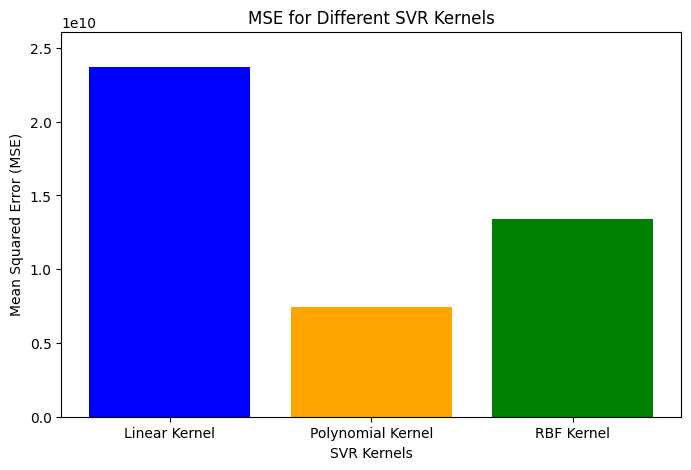

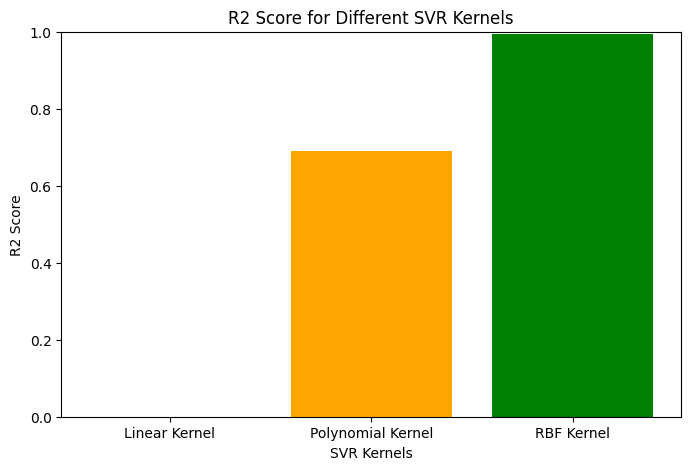

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

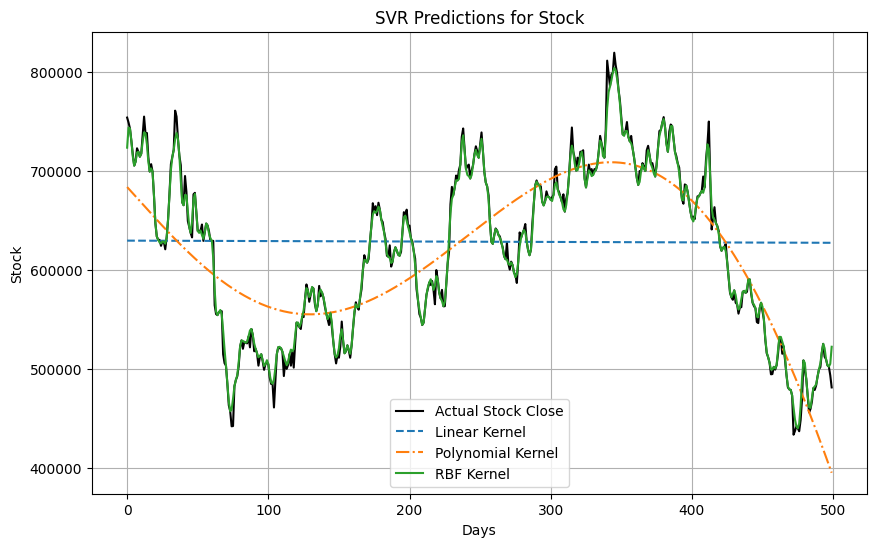

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[8]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/08.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

       Open    High     Low   Close      Adj Close  Volume
0    236000  240000  234500  236000  204594.343750  213578
1    237500  242000  236500  237000  205461.265625  273831
2    234000  234500  230000  231000  200259.703125  217886
3    231500  234500  231000  232000  201126.671875  138750
4    229000  229500  226500  228000  197658.953125  340244
..      ...     ...     ...     ...            ...     ...
963  468000  478000  467500  478000  478000.000000       0
964  480000  485500  474000  483000  483000.000000       0
965  481000  488500  477500  483000  483000.000000       0
966  483000  483000  469500  474000  474000.000000       0
967  474000  479000  464000  475000  475000.000000       0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [436138.71332854]
다음 날 예측 (polynomial, HL):  [443186.22744842]
다음 날 예측 (RBF, HL):  [367430.82132672]
최종 예측 값: [415585.25403456]


성능지표 시각화

Linear 모델 MSE: 1510199601.7617223
Polynomial 모델 MSE: 1012116123.963427
RBF 모델 MSE: 11571128200.444023
R2 스코어 (linear):  0.5453126282081903
R2 스코어 (polynomial):  0.8814556885329133
R2 스코어 (RBF):  0.9668742941942476


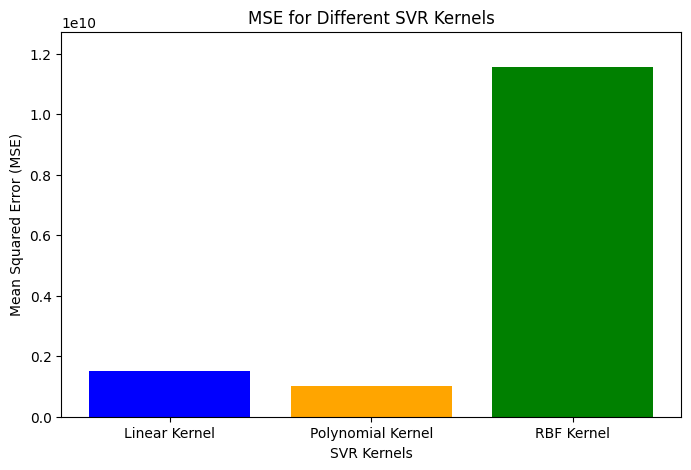

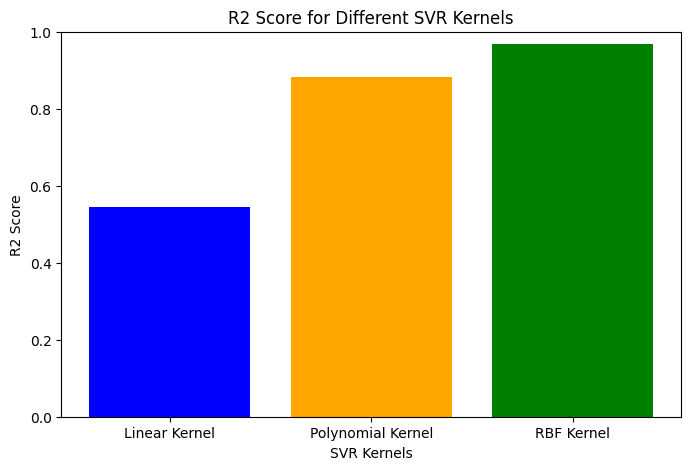

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

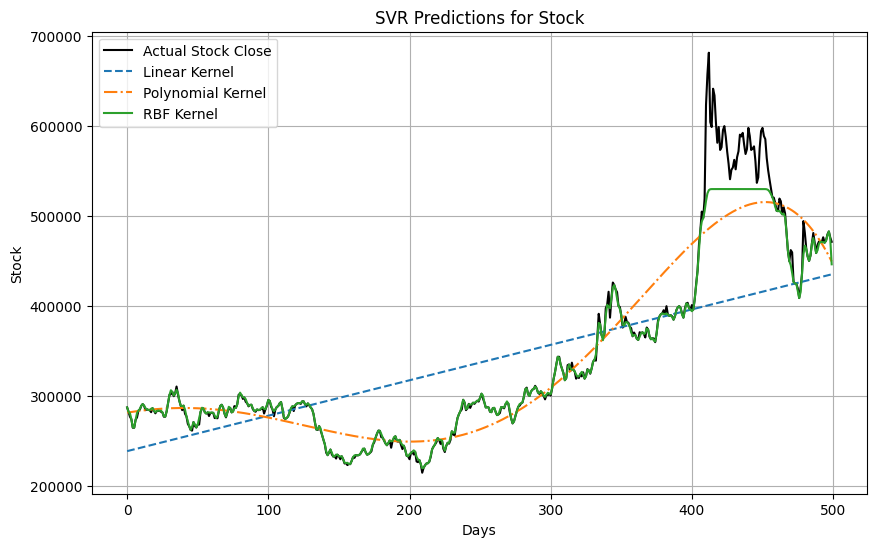

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[9]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/09.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

       Open    High     Low   Close      Adj Close  Volume
0    237000  237500  231500  232000  230847.562500  186494
1    235000  235500  228500  229000  227862.453125  239332
2    227000  230500  226000  230000  228857.500000  151022
3    230000  233500  229000  231500  230350.046875  153608
4    229000  231000  227000  229000  227862.453125  262681
..      ...     ...     ...     ...            ...     ...
963  456500  459500  452500  455000  455000.000000       0
964  460500  474500  454000  471500  471500.000000       0
965  471000  473500  463500  472000  472000.000000       0
966  467500  467500  447000  447000  447000.000000       0
967  451000  456000  433500  439500  439500.000000       0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [659153.97604772]
다음 날 예측 (polynomial, HL):  [353211.27762182]
다음 날 예측 (RBF, HL):  [591218.63845959]
최종 예측 값: [534527.96404304]


성능지표 시각화

Linear 모델 MSE: 48247869193.57325
Polynomial 모델 MSE: 7445743609.658685
RBF 모델 MSE: 23018545256.03126
R2 스코어 (linear):  -0.06413926458914276
R2 스코어 (polynomial):  0.7591184487450546
R2 스코어 (RBF):  0.9945216535797492


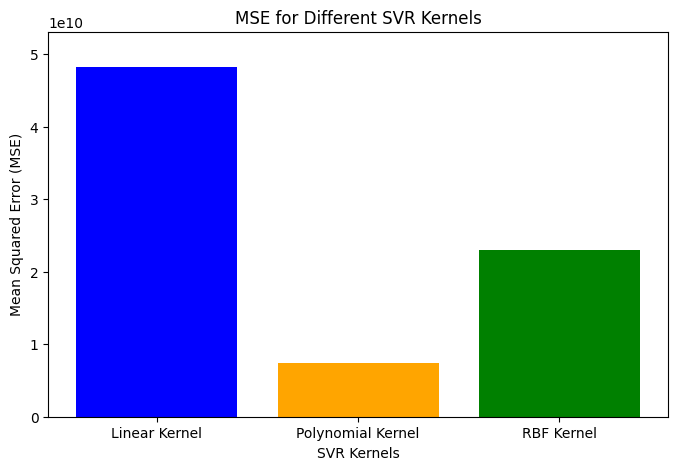

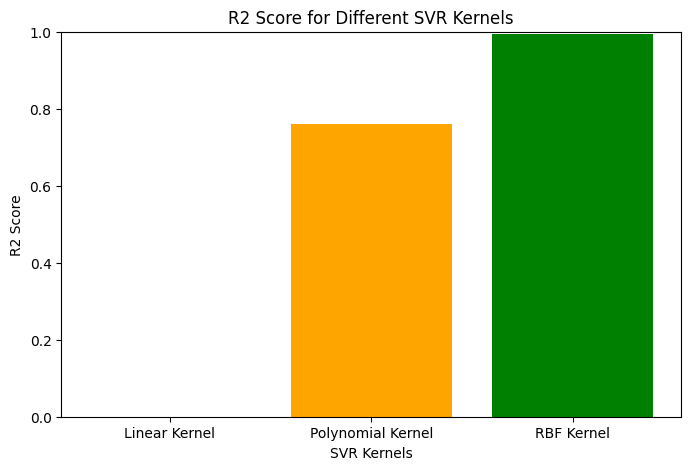

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

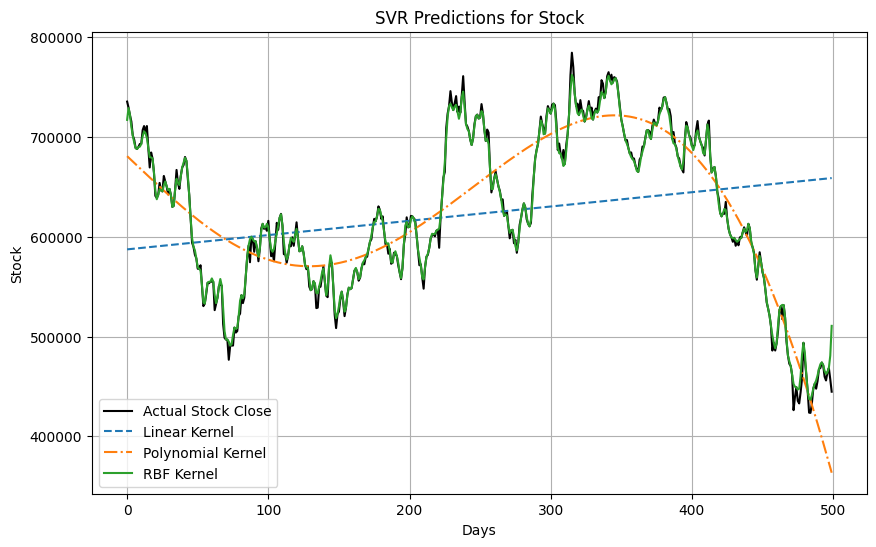

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[10]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/10.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

      Open   High    Low  Close     Adj Close   Volume
0    47250  47450  46450  46550  38854.375000  1033855
1    47050  47800  46900  47150  39355.187500  1123490
2    47100  47550  46300  46600  38896.113281   698224
3    46600  47350  46600  47000  39229.980469   817477
4    46100  46550  45800  46150  38520.503906  1197780
..     ...    ...    ...    ...           ...      ...
963  51600  52700  51100  52400  52400.000000        0
964  51800  52200  51500  51700  51700.000000        0
965  51700  52600  51500  52400  52400.000000        0
966  52600  52800  51900  51900  51900.000000        0
967  52400  52400  51500  51500  51500.000000        0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [46793.86768033]
다음 날 예측 (polynomial, HL):  [54762.94878493]
다음 날 예측 (RBF, HL):  [51106.78589387]
최종 예측 값: [50887.86745305]


성능지표 시각화

Linear 모델 MSE: 22147681.410208803
Polynomial 모델 MSE: 10646834.773105545
RBF 모델 MSE: 154617.33326150238
R2 스코어 (linear):  0.10705835458540613
R2 스코어 (polynomial):  0.49850371942960503
R2 스코어 (RBF):  0.9979534835833703


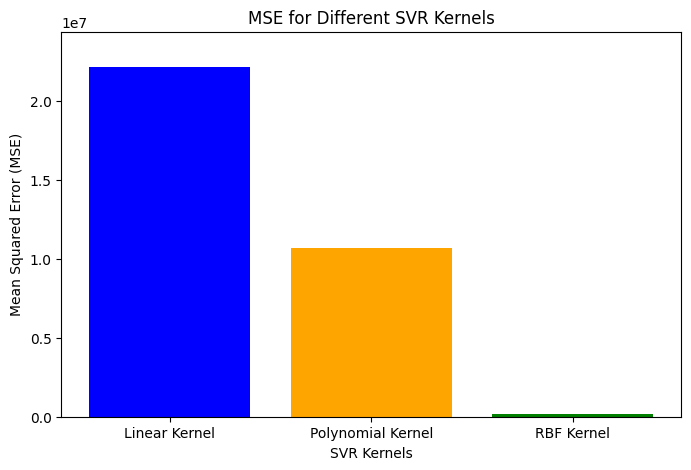

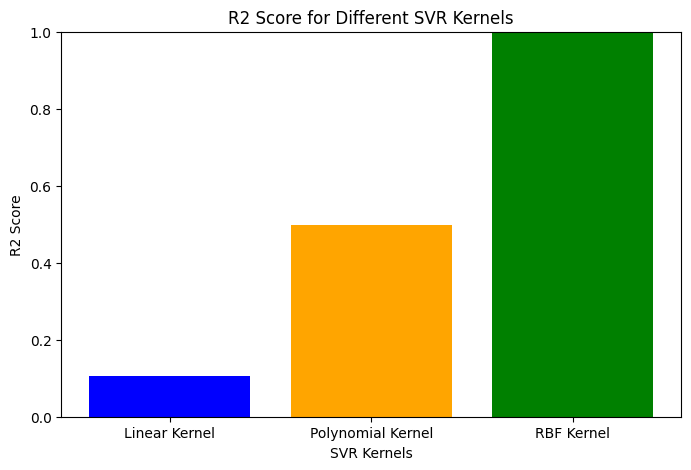

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

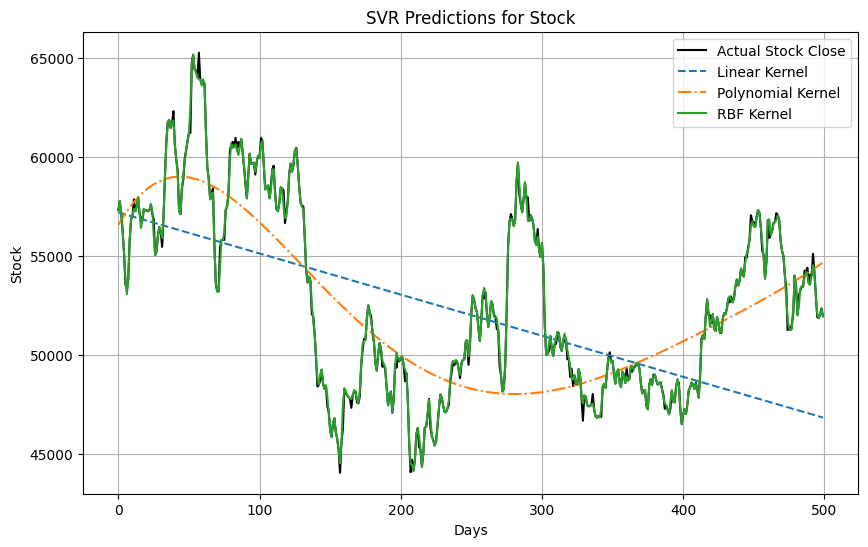

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[11]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/11.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

       Open    High     Low   Close      Adj Close  Volume
0     71800   72100   71000   71000   69337.203125  284758
1     71400   71900   70800   71100   69434.867188  369493
2     70300   70500   69600   69900   68262.968750  337026
3     69800   70600   69800   70300   68653.601562  265311
4     70300   70300   67000   67500   65919.179688  265311
..      ...     ...     ...     ...            ...     ...
963  105000  105800  103700  104500  104500.000000       0
964  104200  104900  103000  103400  103400.000000       0
965  103000  104000  102500  102700  102700.000000       0
966  103200  103800  102300  102400  102400.000000       0
967  103100  103300  101300  101600  101600.000000       0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [102906.46011942]
다음 날 예측 (polynomial, HL):  [88850.32257181]
다음 날 예측 (RBF, HL):  [104207.47528289]
최종 예측 값: [98654.75265804]


성능지표 시각화

Linear 모델 MSE: 1706838.0436315567
Polynomial 모델 MSE: 162554274.52296695
RBF 모델 MSE: 6798927.350856683
R2 스코어 (linear):  -0.01655088154045825
R2 스코어 (polynomial):  0.7378490114535595
R2 스코어 (RBF):  0.9985770034469512


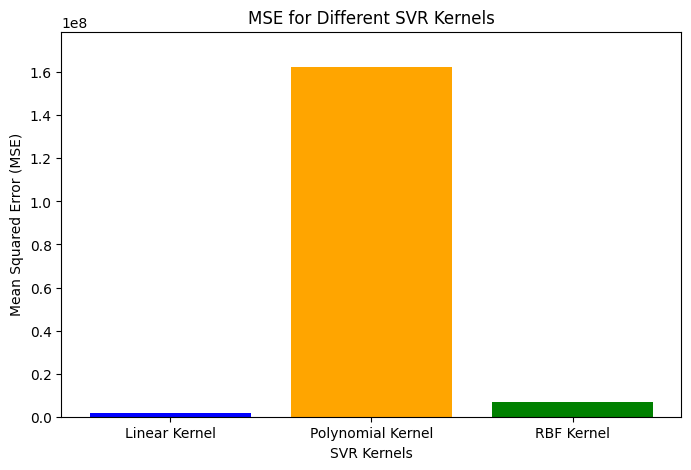

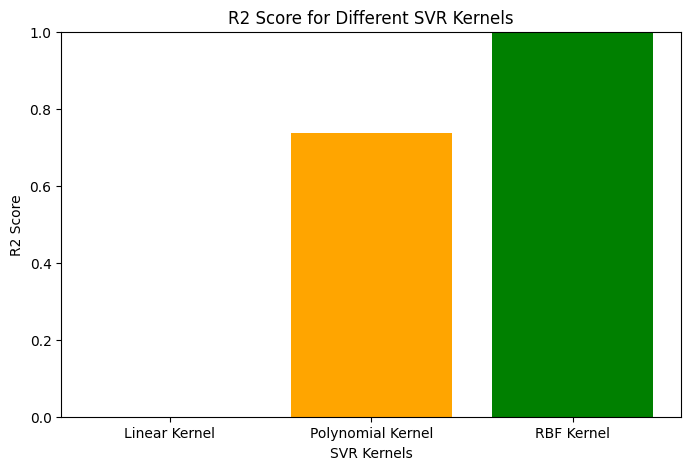

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

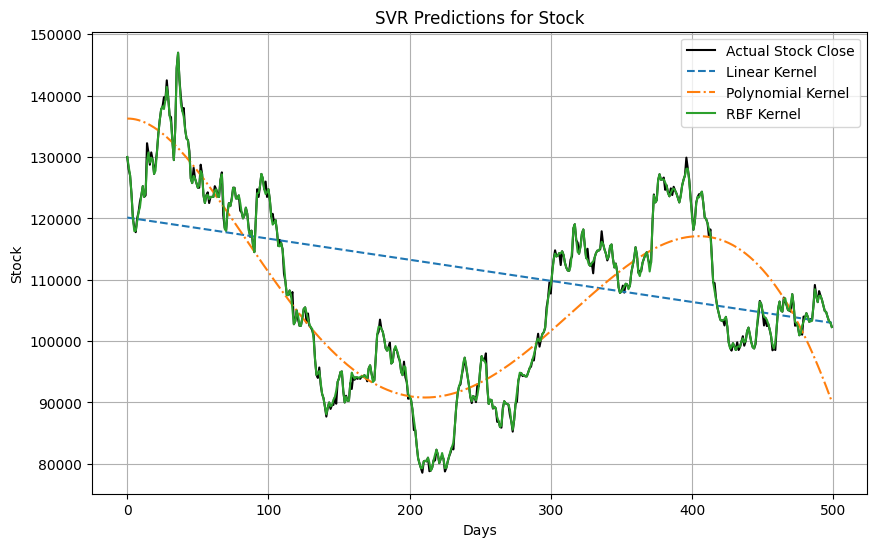

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[12]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/12.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

              Open           High            Low          Close  \
0    110659.898438  111675.125000  108121.828125  109137.054688   
1    110152.281250  111167.515625  108629.445312  109137.054688   
2    107614.210938  108629.445312  106598.984375  107614.210938   
3    108629.445312  109644.671875  108121.828125  109644.671875   
4    108121.828125  108629.445312  104568.531250  106598.984375   
..             ...            ...            ...            ...   
963  118000.000000  119000.000000  117100.000000  119000.000000   
964  118300.000000  119100.000000  117800.000000  117800.000000   
965  117800.000000  119300.000000  117100.000000  119300.000000   
966  118900.000000  119600.000000  118400.000000  118600.000000   
967  119500.000000  120700.000000  118900.000000  120500.000000   

         Adj Close  Volume  
0    101530.867188  229273  
1    101530.867188  249984  
2    100114.156250  232788  
3    102003.101562  197459  
4     99169.679688  402954  
..             ...   

모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [106954.78925904]
다음 날 예측 (polynomial, HL):  [120720.1447616]
다음 날 예측 (RBF, HL):  [115952.97085793]
최종 예측 값: [114542.63495952]


성능지표 시각화

Linear 모델 MSE: 183472734.01704967
Polynomial 모델 MSE: 48463.71606064825
RBF 모델 MSE: 20675474.018832993
R2 스코어 (linear):  0.11413170082286561
R2 스코어 (polynomial):  0.5441242852489706
R2 스코어 (RBF):  0.9919245535809345


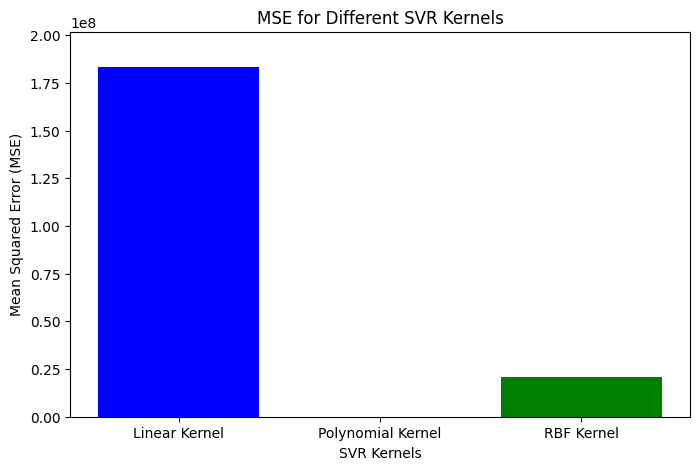

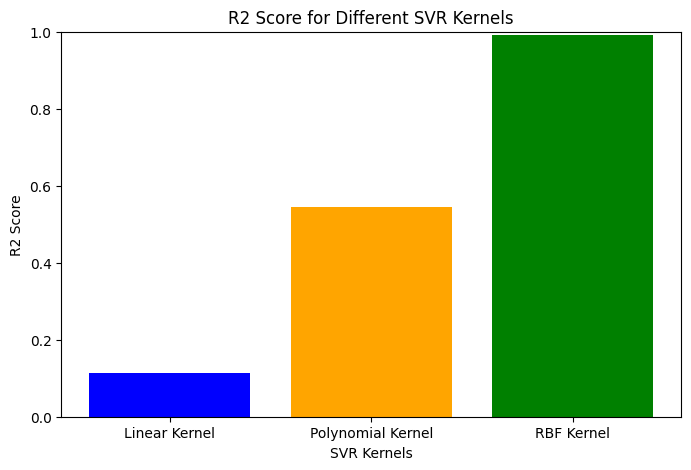

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

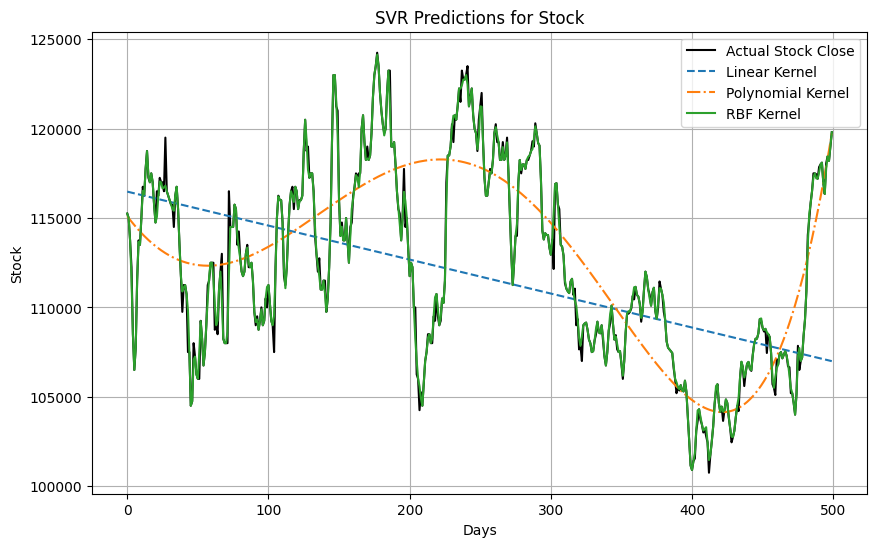

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()

[13]

In [ ]:
filename = '/content/drive/MyDrive/Given Data_10/13.xlsx'  # 파일 경로 지정
df = pd.read_excel(filename, engine='openpyxl')  # Excel 파일을 DataFrame으로 읽어옵니다
df.drop('Date', axis=1, inplace=True)  # 'Date' 열을 삭제합니다
processed_df = preprocess_stock_data(df)  # 데이터 전처리 함수를 적용합니다
print(processed_df)  # 전처리된 데이터를 출력합니다

fin = processed_df.tail(500)  # 마지막 500개의 행을 선택하여 데이터프레임에 저장합니다

stock_HL = fin[['High','Low']].mean(axis=1)  # 'High'와 'Low' 열의 값들을 평균하여 새로운 변수에 저장합니다
stock_HL = stock_HL.values  # 계산된 평균 값을 배열 형태로 저장합니다

days = [] #임의로 데이터당 숫자 지정
for i in range(len(fin)):
  days.append([int(i)])
  i=i+1

weights = np.ones(len(stock_HL))  # stock_HL과 같은 크기의 1로 이루어진 배열을 생성합니다
weights[:800] = 0.7  # 처음 800개의 요소에는 가중치 0.7

         Open      High       Low     Close      Adj Close  Volume
0    150500.0  151000.0  146500.0  146500.0  146499.984375  217016
1    147500.0  150000.0  146500.0  149500.0  149499.984375  274987
2    151000.0  153000.0  147000.0  148000.0  147999.984375  317436
3    148000.0  148500.0  144000.0  144500.0  144499.984375  324559
4    144000.0  144000.0  136000.0  137000.0  136999.984375  703267
..        ...       ...       ...       ...            ...     ...
963  141000.0  142800.0  140400.0  141300.0  141300.000000       0
964  141800.0  142700.0  140100.0  142300.0  142300.000000       0
965  141600.0  143100.0  140100.0  143100.0  143100.000000       0
966  141500.0  141500.0  134400.0  134400.0  134400.000000       0
967  136500.0  137900.0  134600.0  135800.0  135800.000000       0

[968 rows x 6 columns]


모델 생성/학습/예측

In [ ]:
# 선형 커널을 사용하는 SVR 모델 생성 및 학습
lin_svr_HL = SVR(kernel='linear', C=7000)  # 선형 커널을 갖는 SVR 모델을 생성합니다
lin_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# 다항식 커널을 사용하는 SVR 모델 생성 및 학습
poly_svr_HL = SVR(kernel='poly', C=7000, degree=5, coef0=1.0)  # 다항식 커널을 갖는 SVR 모델을 생성합니다
poly_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

# RBF 커널을 사용하는 SVR 모델 생성 및 학습
rbf_svr_HL = SVR(kernel='rbf', C=70000, gamma=0.2)  # RBF 커널을 갖는 SVR 모델을 생성합니다
rbf_svr_HL.fit(days, stock_HL, sample_weight=weights)  # 주어진 데이터와 가중치를 사용하여 모델을 학습합니다

day = np.array([[len(fin) + 1]])  # 새로운 데이터에 대한 날짜를 배열로 생성합니다

# 각 SVR 모델을 사용하여 새로운 날짜의 'High'와 'Low' 평균값 예측
lin_HL_predictions = lin_svr_HL.predict(day)  # 선형 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
poly_HL_predictions = poly_svr_HL.predict(day)  # 다항식 커널 모델로 'High'와 'Low'의 평균값을 예측합니다
rbf_HL_predictions = rbf_svr_HL.predict(day)  # RBF 커널 모델로 'High'와 'Low'의 평균값을 예측합니다

print('다음 날 예측 (linear, HL): ', lin_HL_predictions)  # 선형 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (polynomial, HL): ', poly_HL_predictions)  # 다항식 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력
print('다음 날 예측 (RBF, HL): ', rbf_HL_predictions)  # RBF 커널 모델로부터 예측된 'High'와 'Low'의 평균값 출력

final_prediction = (lin_HL_predictions + poly_HL_predictions + rbf_HL_predictions) / 3  # 세 모델의 예측값의 평균을 계산합니다
print('최종 예측 값:', final_prediction)  # 최종 예측값을 출력합니다

다음 날 예측 (linear, HL):  [143621.78648825]
다음 날 예측 (polynomial, HL):  [105932.29487007]
다음 날 예측 (RBF, HL):  [163186.80014082]
최종 예측 값: [137580.29383304]


성능지표 시각화

Linear 모델 MSE: 61180343.86772405
Polynomial 모델 MSE: 892079809.7286811
RBF 모델 MSE: 750036821.9530833
R2 스코어 (linear):  0.5249544261923291
R2 스코어 (polynomial):  0.7194037736297969
R2 스코어 (RBF):  0.9973064279824679


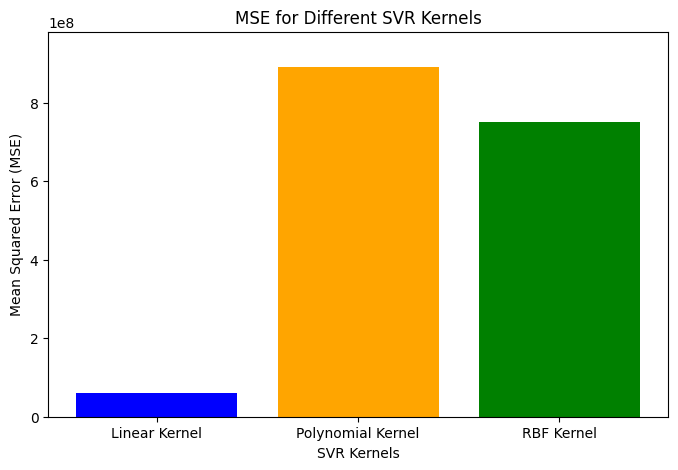

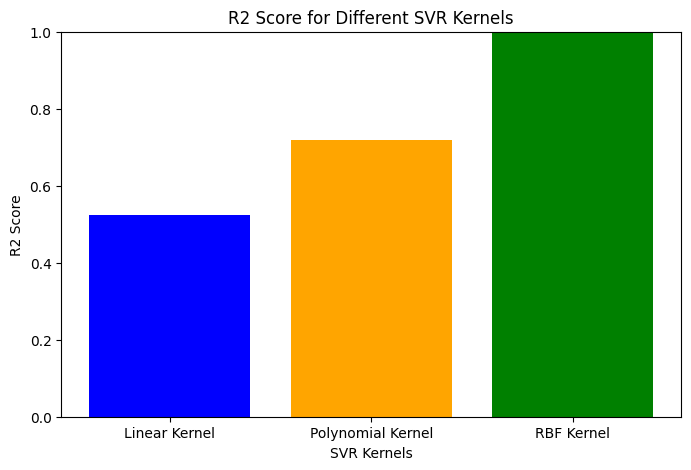

In [ ]:
# 실제 다음 날 종가 값 가져오기
actual_next_day_close = df.iloc[-1]['Close']  # 데이터프레임에서 마지막 행의 'Close' 열 값을 실제 다음 날 종가 값으로 설정합니다

# 각 모델의 예측값과 실제값 간의 MSE 계산
lin_HL_mse = mean_squared_error([actual_next_day_close], lin_HL_predictions)  # 선형 커널 모델의 MSE 계산
poly_HL_mse = mean_squared_error([actual_next_day_close], poly_HL_predictions)  # 다항식 커널 모델의 MSE 계산
rbf_HL_mse = mean_squared_error([actual_next_day_close], rbf_HL_predictions)  # RBF 커널 모델의 MSE 계산

print('Linear 모델 MSE:', lin_HL_mse)  # 선형 커널 모델의 MSE 출력
print('Polynomial 모델 MSE:', poly_HL_mse)  # 다항식 커널 모델의 MSE 출력
print('RBF 모델 MSE:', rbf_HL_mse)  # RBF 커널 모델의 MSE 출력

# 각 모델로 전체 데이터에 대한 예측 수행
lin_HL_predictionss = lin_svr_HL.predict(days)  # 선형 커널 모델로 전체 데이터에 대한 예측 수행
poly_HL_predictionss = poly_svr_HL.predict(days)  # 다항식 커널 모델로 전체 데이터에 대한 예측 수행
rbf_HL_predictionss = rbf_svr_HL.predict(days)  # RBF 커널 모델로 전체 데이터에 대한 예측 수행

# 각 모델의 R2 스코어 계산
lin_HL_r2 = r2_score(stock_HL, lin_HL_predictionss, sample_weight=weights)  # 선형 커널 모델의 R2 스코어 계산
poly_HL_r2 = r2_score(stock_HL, poly_HL_predictionss, sample_weight=weights)  # 다항식 커널 모델의 R2 스코어 계산
rbf_HL_r2 = r2_score(stock_HL, rbf_HL_predictionss, sample_weight=weights)  # RBF 커널 모델의 R2 스코어 계산

# 계산된 R2 스코어 출력
print('R2 스코어 (linear): ', lin_HL_r2)  # 선형 커널 모델의 R2 스코어 출력
print('R2 스코어 (polynomial): ', poly_HL_r2)  # 다항식 커널 모델의 R2 스코어 출력
print('R2 스코어 (RBF): ', rbf_HL_r2)  # RBF 커널 모델의 R2 스코어 출력

# MSE 시각화
models = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel']
mse_values = [lin_HL_mse, poly_HL_mse, rbf_HL_mse]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different SVR Kernels')
plt.ylim(0, max(mse_values) * 1.1)  # y축 범위 설정
plt.show()

# R2 스코어 시각화
r2_values = [lin_HL_r2, poly_HL_r2, rbf_HL_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.xlabel('SVR Kernels')
plt.ylabel('R2 Score')
plt.title('R2 Score for Different SVR Kernels')
plt.ylim(0, 1)  # R2는 0~1 범위 내에서 변동
plt.show()

전체 흐름 시각화

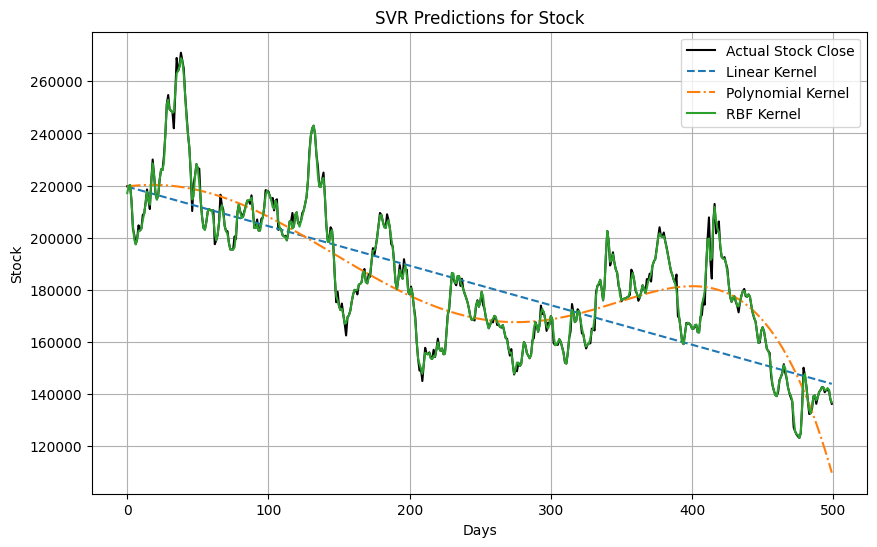

In [ ]:
new_days = np.arange(len(fin))  # 예측값의 길이를 맞추기 위해 새로운 날짜 범위를 생성합니다

# 예측값의 길이를 new_days와 동일하도록 조정
lin_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
poly_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다
rbf_HL_predictions.reshape(-1, 1)  # 예측값의 길이를 new_days와 동일하도록 조정합니다

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, stock_HL, label='Actual Stock Close', color='black')  # 실제 주식 종가 데이터를 그립니다

# 각 모델의 예측값을 시각화합니다
plt.plot(new_days, lin_HL_predictionss, label='Linear Kernel', linestyle='--')  # 선형 커널 모델의 예측값을 그립니다
plt.plot(new_days, poly_HL_predictionss, label='Polynomial Kernel', linestyle='-.')  # 다항식 커널 모델의 예측값을 그립니다
plt.plot(new_days, rbf_HL_predictionss, label='RBF Kernel', linestyle='-')  # RBF 커널 모델의 예측값을 그립니다

plt.xlabel('Days')
plt.ylabel('Stock')
plt.title('SVR Predictions for Stock')
plt.legend()
plt.grid(True)
plt.show()